In [1]:
import os

import torch 
from torch import optim, nn
from torch.optim import lr_scheduler
from torch.nn import functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint

from collections import OrderedDict

In [2]:
class MyModel(LightningModule):
    def __init__(self, model, hparams, num_workers=0, log_train_every_epoch=False):
        super().__init__()
        self.hparams = hparams
        self.model = model
        self.num_workers = num_workers
        self.log_train_every_epoch = log_train_every_epoch

    def forward(self, x):
        return self.model(x)
    
    @classmethod
    def _accuracy(cls, output, target):
        pred = output.argmax(dim=1, keepdim=True)
        eq = pred.eq(target.view_as(pred))
        return eq.all(dim=-1).float().mean()       

    def training_step(self, batch, batch_idx):
        images, target = batch
        output = self(images)
        loss = F.nll_loss(output, target)
        acc = self._accuracy(output, target)
        
        if self.log_train_every_epoch:
            return {'loss': loss, 'log': {'loss': loss.item(), 'acc': acc.item()}}
        else:
            return {'loss': loss, 'acc': acc.item()}

    def training_epoch_end(self, outputs):
        if self.log_train_every_epoch:
            return
        else:
            keys = outputs[0].keys()
            o_dict = {}
            for k in keys:
                # if k != 'loss':
                o_dict[k] = sum([o[k] for o in outputs]) / len(outputs)
            
        return {'log': o_dict}     
    
    def validation_step(self, batch, batch_idx):
        images, target = batch
        output = self(images)
        loss = F.nll_loss(output, target)
        acc = self._accuracy(output, target)

        return {'val_loss': loss.item(), 'val_acc': acc.item()}

    def validation_epoch_end(self, outputs):
        keys = outputs[0].keys()
        o_dict = {}
        for k in keys:
            o_dict[k] = sum([o[k] for o in outputs]) / len(outputs)
            
        return {'log': o_dict}
    
    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.hparams['lr'],
            momentum=self.hparams['momentum'],
            weight_decay=self.hparams['weight_decay']
        )
        
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=self.hparams['lr_shed_gamma'])
        
        return [optimizer], [scheduler]
    
    def prepare_data(self):
        self.normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                              std=[0.2023, 0.1994, 0.2010])

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, 4),
                transforms.ToTensor(),
                self.normalize,
            ]), download=True),
            batch_size=self.hparams['batch_size'], shuffle=True,
            num_workers=self.num_workers, pin_memory=True)
        
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                self.normalize,
            ])),
            batch_size=self.hparams['batch_size'], shuffle=False,
            num_workers=self.num_workers, pin_memory=True)
        
        return val_loader

In [3]:
import sys

sys.path.append('../../../captcha/lib/')

from models import resnet_mini_custom

In [4]:
backbone_model = resnet_mini_custom.resnet20(num_classes=10)

In [5]:
backbone_model.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [6]:
model = MyModel(backbone_model, {
    'batch_size': 256,
    'lr': 0.01,
    'momentum': 0,
    'weight_decay': 1e-4,  
    'lr_shed_gamma': 0.96
})

In [7]:
os.getcwd()

'/home/ruslan/notebooks/pcancer/train/notebooks'

In [8]:
# DEFAULTS used by the Trainer
checkpoint_callback = ModelCheckpoint(
    save_top_k=-1
)

In [9]:
trainer = Trainer(checkpoint_callback=checkpoint_callback, max_epochs=90, 
                  gpus=[1,], fast_dev_run=False)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [1]


In [14]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 31516), started 13:46:26 ago. (Use '!kill 31516' to kill it.)

In [11]:
trainer.fit(model)

INFO:lightning:
   | Name                    | Type        | Params
----------------------------------------------------
0  | model                   | ResNet      | 269 K 
1  | model.conv1             | Conv2d      | 432   
2  | model.bn1               | BatchNorm2d | 32    
3  | model.layer1            | Sequential  | 14 K  
4  | model.layer1.0          | BasicBlock  | 4 K   
5  | model.layer1.0.conv1    | Conv2d      | 2 K   
6  | model.layer1.0.bn1      | BatchNorm2d | 32    
7  | model.layer1.0.conv2    | Conv2d      | 2 K   
8  | model.layer1.0.bn2      | BatchNorm2d | 32    
9  | model.layer1.0.shortcut | Sequential  | 0     
10 | model.layer1.1          | BasicBlock  | 4 K   
11 | model.layer1.1.conv1    | Conv2d      | 2 K   
12 | model.layer1.1.bn1      | BatchNorm2d | 32    
13 | model.layer1.1.conv2    | Conv2d      | 2 K   
14 | model.layer1.1.bn2      | BatchNorm2d | 32    
15 | model.layer1.1.shortcut | Sequential  | 0     
16 | model.layer1.2          | BasicBlock  | 4 

/home/ruslan/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


/home/ruslan/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [12]:
# !rm -r logs

In [13]:
# trainer.test()

In [ ]:
# from sklearn import metrics
# metrics.cohen_kappa_score(y, X_p, weights='quadratic')

In [ ]:
'''
@dataclass
class KappaScore(ConfusionMatrix):
    "Computes the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)
'''

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [170]:
from warmup_scheduler import GradualWarmupScheduler

from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingLRWithWarmup(_LRScheduler):
    def __init__(self, optimizer, multiplier, warmup_epoch, total_epoch):
        for pg in optimizer.param_groups:
            pg['lr'] /= multiplier
        self.cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                                           total_epoch-warmup_epoch, 
                                                                           eta_min=0, 
                                                                           last_epoch=-1)
        self.warmup_scheduler = GradualWarmupScheduler(optimizer, 
                                                       multiplier=multiplier, 
                                                       total_epoch=warmup_epoch, 
                                                       after_scheduler=self.cosine_scheduler)
        super().__init__(optimizer)

    def step(self, epoch=None, metrics=None):
        return self.warmup_scheduler.step(epoch)

In [171]:
optimizer = optim.Adam([torch.tensor([0])], lr=0.001)

In [172]:
#lr_sheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=60, 
#                                                                   T_mult=2, eta_min=0, last_epoch=-1)

In [173]:
epochs = 200

In [174]:
lr_sheduler = CosineAnnealingLRWithWarmup(optimizer, 40, epochs // 20, epochs)

In [175]:
epochs = np.arange(epochs)

In [176]:
lrs = []
for e in epochs:
    lr_sheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

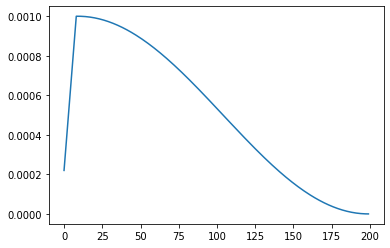

In [177]:
plt.plot(epochs, lrs);

In [178]:
min(lrs)

0.0

In [179]:
max(lrs)

0.001